# History Embedding

> Embed an environment into a more complex representation of state/observation-action histories

In [1]:
#| default_exp Environments/HistoryEmbedding

In [2]:
#| hide
# Imports for the nbdev development environment
# from nbdev.showdoc import *
from fastcore.test import *

In [3]:
#| hide
%load_ext autoreload
%autoreload 2

## Examples

In [4]:
#|eval: true notest
import numpy as np
import matplotlib.pyplot as plt
import copy

from pyCRLD.Environments.SocialDilemma import SocialDilemma
from pyCRLD.Environments.EcologicalPublicGood import EcologicalPublicGood

from pyCRLD.Agents.StrategyActorCritic import stratAC
from pyCRLD.Agents.POStrategyActorCritic import POstratAC

from pyCRLD.Utils import FlowPlot as fp

np.random.seed(42)

In [5]:
from pyCRLD.Environments.HistoryEmbedding import HistoryEmbedded

Visualizing the flow of learning in the prosperous state:

Only action

In [6]:
#| hide
# import nbdev; nbdev.nbdev_export()

In [7]:
class Information_Conditions:
    def __init__(self, ecopg_with_history, mode):
        self.ecopg_with_history = ecopg_with_history
        self.mode = mode
        self.ecopg_with_history_partially_observed = copy.deepcopy(self.ecopg_with_history)
        self.configure_information_condition()


    def configure_information_condition(self):
        """
        Set the observation mode and configure the observation tensor, Oset, and other properties.
        Modes: 'state', 'action', 'none', 'state+action'
        """
        if self.mode == "only_state_information":
            self._configure_state()
        elif self.mode == "only_action_history_information":
            self._configure_action()
        elif self.mode == "no_information":
            self._configure_none()
        elif self.mode == "both_state_and_action_information":
            self._configure_state_action()
        else:
            raise ValueError("Invalid mode..")
        self._print_configuration()

    def _configure_state(self):
        def generate_state_tensor(state_set, observation_set):
            state_tensor = np.zeros((2, len(state_set), len(observation_set)), dtype=int)
            for i in range(2):
                for j, state in enumerate(state_set):
                    for k, observation in enumerate(observation_set):
                        if state.endswith(observation):
                            state_tensor[i, j, k] = 1
            return state_tensor
        
        
        stateset = ['c,c,g|', 'c,c,p|', 'c,d,g|', 'c,d,p|', 'd,c,g|', 'd,c,p|', 'd,d,g|', 'd,d,p|']
        self.ecopg_with_history_partially_observed.Oset = [['g|', 'p|'], ['g|', 'p|']]

        self.ecopg_with_history_partially_observed.O = generate_state_tensor(
            stateset,  self.ecopg_with_history_partially_observed.Oset[0])
        

    def _configure_action(self):
        def generate_action_tensor(state_set, action_set):
            action_tensor = np.zeros((2, len(state_set), len(action_set)), dtype=int)
            for i in range(2):  
                for j, state in enumerate(state_set):
                    for k, action in enumerate(action_set):
                        if action[:3] == state[:3]:
                            action_tensor[i, j, k] = 1
            return action_tensor

        stateset = ['c,c,g|', 'c,c,p|', 'c,d,g|', 'c,d,p|', 'd,c,g|', 'd,c,p|', 'd,d,g|', 'd,d,p|']
        observations = ['c,c,.|', 'c,d,.|', 'd,c,.|', 'd,d,.|']
        self.ecopg_with_history_partially_observed = copy.deepcopy(self.ecopg_with_history)
        self.ecopg_with_history_partially_observed.O = generate_action_tensor(stateset, observations)
        self.ecopg_with_history_partially_observed.Oset = [['c,c,.|', 'c,d,.|', 'd,c,.|', 'd,d,.|'], ['c,c,.|', 'c,d,.|', 'd,c,.|', 'd,d,.|']]

    def _configure_none(self):
        def generate_none_tensor():
            return np.ones((2, 8, 1), dtype=int)

        self.ecopg_with_history_partially_observed = copy.deepcopy(self.ecopg_with_history)
        self.ecopg_with_history_partially_observed.O = generate_none_tensor()
        self.ecopg_with_history_partially_observed.Oset = [['.'], ['.']]

    def _configure_state_action(self):
        # This assumes the default state+action information in `ecopg_with_history`
        self.ecopg_with_history_partially_observed = copy.deepcopy(self.ecopg_with_history)

          # No modification needed; default setup already uses state+action information.

    def _print_configuration(self):
        print(f"Mode: {self.mode}")
        print("Observation Tensor:\n", self.ecopg_with_history_partially_observed.O)
        print("Observation Set:", self.ecopg_with_history_partially_observed.Oset)
        print("------\n")




In [8]:
ecopg = EcologicalPublicGood(N=2, f=1.2, c=5, m=-4, qc=0.2, qr=0.1, degraded_choice=True)
ecopg_with_history = HistoryEmbedded(ecopg, h = (1,1,1))

# State-only configuration
action_only_information_condition = Information_Conditions(ecopg_with_history, mode = "only_action_history_information")
action_only_information_condition.ecopg_with_history_partially_observed
# Action-only configuration


Mode: only_action_history_information
Observation Tensor:
 [[[1 0 0 0]
  [1 0 0 0]
  [0 1 0 0]
  [0 1 0 0]
  [0 0 1 0]
  [0 0 1 0]
  [0 0 0 1]
  [0 0 0 1]]

 [[1 0 0 0]
  [1 0 0 0]
  [0 1 0 0]
  [0 1 0 0]
  [0 0 1 0]
  [0 0 1 0]
  [0 0 0 1]
  [0 0 0 1]]]
Observation Set: [['c,c,.|', 'c,d,.|', 'd,c,.|', 'd,d,.|'], ['c,c,.|', 'c,d,.|', 'd,c,.|', 'd,d,.|']]
------



HistoryEmbeddedEcologicalPublicGood_2_1.2_5_-4_0.2_0.1_DegChoi_h(1, 1, 1)

In [26]:
information_condition_instance = Information_Conditions(ecopg_with_history, mode = "only_state_information")
mae = POstratAC(env=information_condition_instance.ecopg_with_history_partially_observed, learning_rates=0.1, discount_factors=0.9)
x =  mae.random_softmax_strategy()
# x = np.random.rand(2, 4, 2)

print(x)
print(np.shape(x))
  # from a random inital strategy
xtraj, fixedpointreached = mae.trajectory(x, Tmax=10000, tolerance=1e-5)

print(x)
# PLOT
# fig, axs = plt.subplots(1,2, figsize=(9,4))
# plt.subplots_adjust(wspace=0.3)

# Plot in phase space
num_observed_states = len(information_condition_instance.ecopg_with_history_partially_observed.Oset[0])
x, y = ([0], list(range(num_observed_states)), [0]), ([1], list(range(num_observed_states)), [0])
ax = fp.plot_strategy_flow(mae, x, y, use_RPEarrows=False, flowarrow_points = np.linspace(0.01 ,0.99, 9), conds = np.array(information_condition_instance.ecopg_with_history_partially_observed.Oset)[0, :num_observed_states] )
fp.plot_trajectories([xtraj], x, y, cols=['purple'])


# x, y = ([0], [0], [0]), ([1], [0], [0])
# ax = fp.plot_strategy_flow(mae, x, y, use_RPEarrows=False, flowarrow_points = np.linspace(0.01 ,0.99, 9), conds = np.array(information_condition_instance.ecopg_with_history_partially_observed.Oset)[0, :num_observed_states] )
# ax = fp.plot_strategy_flow(mae, x, y, use_RPEarrows=False, flowarrow_points = np.linspace(0.01 ,0.99, 9), axes=[axs[0]], conds = np.array(information_condition_instance.ecopg_with_history_partially_observed.Oset)[0, :num_observed_states] )
# fp.plot_trajectories([xtraj], x, y, cols=['purple'], axes=ax);
# ax[0].set_xlabel("Agent 0's cooperation probability")
# ax[0].set_ylabel("Agent 1's cooperation probability");
# ax[0].set_title("Flowplot")

# Plot in trajectory
# axs[1].plot(xtraj[:, 0, 0, 0], label="Agent 0", c='red')
# axs[1].plot(xtraj[:, 1, 0, 0], label="Agent 1", c='blue')
# axs[1].set_xlabel('Time steps')
# axs[1].set_ylabel('Cooperation probability')
# axs[1].legend()
# axs[1].set_title("Trajectory");

Mode: only_state_information
Observation Tensor:
 [[[1 0]
  [0 1]
  [1 0]
  [0 1]
  [1 0]
  [0 1]
  [1 0]
  [0 1]]

 [[1 0]
  [0 1]
  [1 0]
  [0 1]
  [1 0]
  [0 1]
  [1 0]
  [0 1]]]
Observation Set: [['g|', 'p|'], ['g|', 'p|']]
------

2
[[[0.76637703 0.23362294]
  [0.7637097  0.2362903 ]
  [0.56698954 0.43301046]
  [0.6707789  0.32922116]
  [0.46163732 0.5383627 ]
  [0.7716374  0.22836262]
  [0.8830171  0.11698287]
  [0.39717382 0.6028262 ]]

 [[0.764528   0.23547204]
  [0.8166596  0.18334036]
  [0.3575829  0.6424171 ]
  [0.20838517 0.79161483]
  [0.67309564 0.32690433]
  [0.5948385  0.4051615 ]
  [0.96779794 0.03220206]
  [0.8388186  0.16118139]]]
(2, 8, 2)


ValueError: Size of label 'd' for operand 1 (2) does not match previous terms (8).

In [ ]:
information_condition_instance = Information_Conditions(ecopg_with_history, mode = "only_state_information")
mae = POstratAC(env=information_condition_instance.ecopg_with_history_partially_observed, learning_rates=0.1, discount_factors=0.9)
# x =  np.random.rand(2, 8, 4) 

print(mae.Q)
X_random = mae.random_softmax_strategy()


pc00, pc01, pc10, pc11 = 0.35, 0.35, 0.8, 0.8
X = [[[pc00, 1-pc00],     #initial policy to visulize learning trajectory
      [pc01, 1-pc01]], 
     [[pc10, 1-pc10], 
      [pc11, 1-pc11]]] 
X = np.array(X)



xtraj, fixedpointreached = mae.trajectory(X, Tmax=10000, tolerance=1e-5)

# PLOT
# fig, axs = plt.subplots(1,2, figsize=(9,4))
# plt.subplots_adjust(wspace=0.3)

# Plot in phase space
num_observed_states = len(information_condition_instance.ecopg_with_history_partially_observed.Oset[0])
x, y = ([0], list(range(num_observed_states)), [0]), ([1], list(range(num_observed_states)), [0])
ax = fp.plot_strategy_flow(mae, x, y, use_RPEarrows=False, flowarrow_points = np.linspace(0.01 ,0.99, 9), conds = np.array(information_condition_instance.ecopg_with_history_partially_observed.Oset)[0, :num_observed_states] )
fp.plot_trajectories([xtraj], x, y, cols=['purple'], axes = ax)




Mode: only_state_information
Observation Tensor:
 [[[1 0]
  [0 1]
  [1 0]
  [0 1]
  [1 0]
  [0 1]
  [1 0]
  [0 1]]

 [[1 0]
  [0 1]
  [1 0]
  [0 1]
  [1 0]
  [0 1]
  [1 0]
  [0 1]]]
Observation Set: [['g|', 'p|'], ['g|', 'p|']]
------

2


NameError: name 'X_r' is not defined

Mode: both_state_and_action_information
Observation Tensor:
 [[[1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1.]]

 [[1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1.]]]
Observation Set: [['c,c,g|', 'c,c,p|', 'c,d,g|', 'c,d,p|', 'd,c,g|', 'd,c,p|', 'd,d,g|', 'd,d,p|'], ['c,c,g|', 'c,c,p|', 'c,d,g|', 'c,d,p|', 'd,c,g|', 'd,c,p|', 'd,d,g|', 'd,d,p|']]
------

Mode: only_action_history_information
Observation Tensor:
 [[[1 0 0 0]
  [1 0 0 0]
  [0 1 0 0]
  [0 1 0 0]
  [0 0 1 0]
  [0 0 1 0]
  [0 0 0 1]
  [0 0 0 1]]

 [[1 0 0 0]
  [1 0 0 0]
  [0 1 0 0]
  [0 1 0 0]
  [0 0 1 0]
  [0 0 1 0]
  [0 0 0 1]
  [0 0 0 1]]]
Observation Set: [['c,c,.|', 'c,d,.|', 'd,

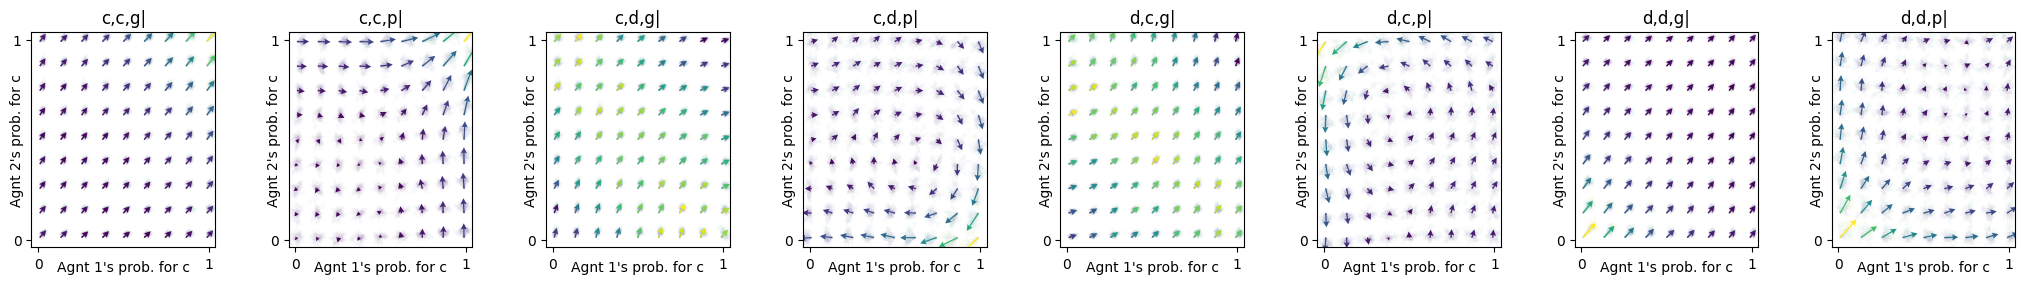

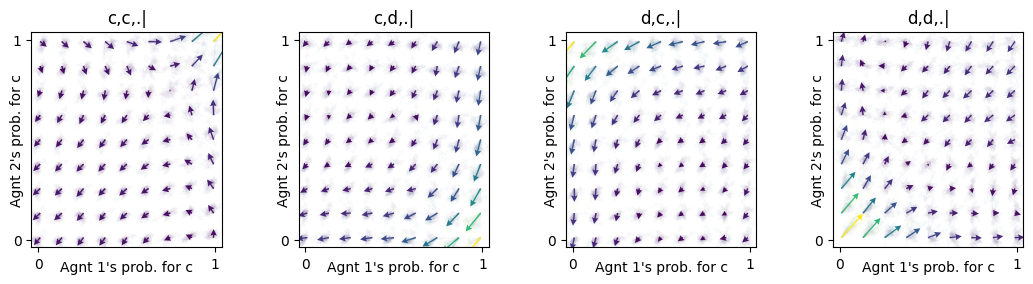

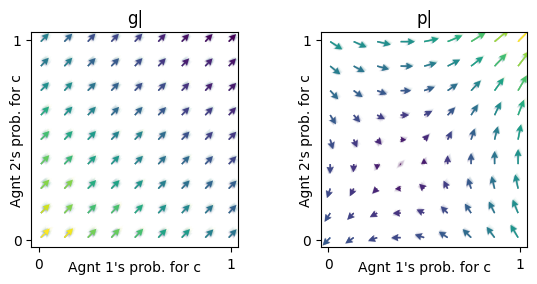

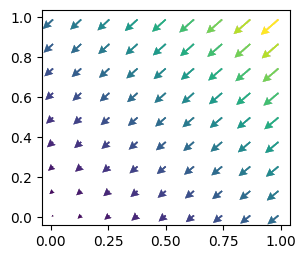

In [22]:
# Generate strategy flows for each mode (example with placeholders)

for mode in ['both_state_and_action_information','only_action_history_information', 'only_state_information','no_information', ]:
    information_condition_instance = Information_Conditions(ecopg_with_history=ecopg_with_history, mode=mode)
    num_observed_states = len(information_condition_instance.ecopg_with_history_partially_observed.Oset[0])
    x, y = ([0], list(range(num_observed_states)), [0]), ([1], list(range(num_observed_states)), [0])
    ax = fp.plot_strategy_flow(
        POstratAC(env=information_condition_instance.ecopg_with_history_partially_observed, learning_rates=0.1, discount_factors=0.9),
        x, y, flowarrow_points=np.linspace(0.01, 0.99, 9), NrRandom=32,
        conds=np.array(information_condition_instance.ecopg_with_history_partially_observed.Oset)[0, :num_observed_states]  # Adjust conditions for the mode
    )


Partial